#Practical notebook: Transfer learning and fine-tuning
---
This notebook is based on <a href="https://www.tensorflow.org/tutorials/images/transfer_learning" class="external">an official notebook from tensorflow</a>. 

In this tutorial, you will learn how to classify images of cats and dogs by using transfer learning from a pre-trained network.

A pre-trained model is a saved network that was previously trained on a large dataset, typically on a large-scale image-classification task. You either use the pretrained model as is or use transfer learning to customize this model to a given task.

The intuition behind transfer learning for image classification is that if a model is trained on a large and general enough dataset, this model will effectively serve as a generic model of the visual world. You can then take advantage of these learned feature maps without having to start from scratch by training a large model on a large dataset.

In this notebook, you will try two ways to customize a pretrained model:

1. Feature Extraction: Use the representations learned by a previous network to extract meaningful features from new samples. You simply add a new classifier, which will be trained from scratch, on top of the pretrained model so that you can repurpose the feature maps learned previously for the dataset.

2. Fine-Tuning: Unfreeze a few of the top layers of a frozen model base and jointly train both the newly-added classifier layers and the last layers of the base model. This allows us to "fine-tune" the higher-order feature representations in the base model in order to make them more relevant for the specific task.

Network to be use: VGG16

![Image in a markdown cell](https://miro.medium.com/max/940/1*3-TqqkRQ4rWLOMX-gvkYwA.png)


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
import numpy as np
from sklearn.utils import shuffle
from IPython.display import clear_output
import matplotlib.pyplot as plt
import os


## Prepare data
---

In [ ]:
# Run this cell to download the Cats and Dogs set
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=_URL, extract=True)
PATH = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')

BATCH_SIZE = 32
IMG_SIZE = (160, 160)
CLASSES = 2

68616192/68606236 [==============================] - 0s 0us/step


Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Using 500 files for training.
Found 1000 files belonging to 2 classes.
Using 500 files for validation.


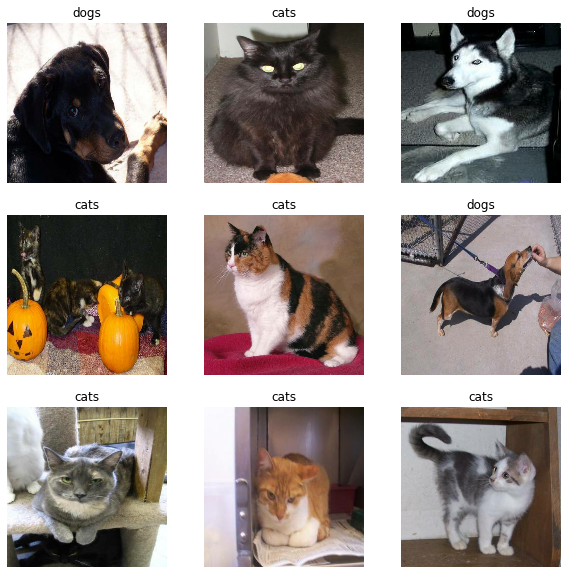

In [ ]:
# Define training and validation dataloader

# Define training from the training directory
train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,

                                                            image_size=IMG_SIZE)
# Split validation set into 50% validation and 50% test 
validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                                 shuffle=True,
                                                                 validation_split=0.5,
                                                                 subset="training",
                                                                 seed=1337,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)

test_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                                 shuffle=True,
                                                                 validation_split=0.5,
                                                                 subset="validation",
                                                                 seed=1337,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)

class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
# Use buffered prefetching to load images from disk without having I/O become blocking.
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)


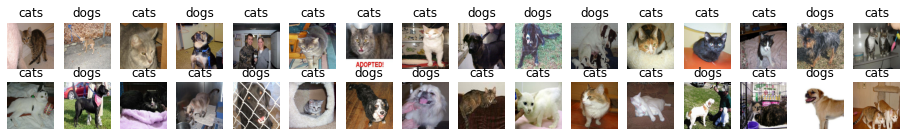

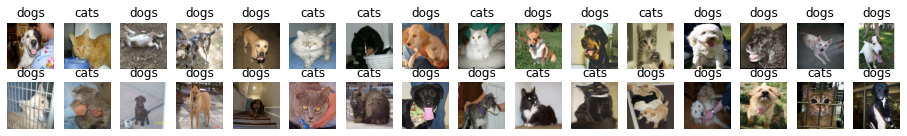

In [ ]:
plt.figure(figsize=(16, 2))
for images, labels in validation_dataset.take(1):
  for i in range(32):
    ax = plt.subplot(2, 16, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

plt.figure(figsize=(16, 2))
for images, labels in test_dataset.take(1):
  for i in range(32):
    ax = plt.subplot(2, 16, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

## Data augmentation
---

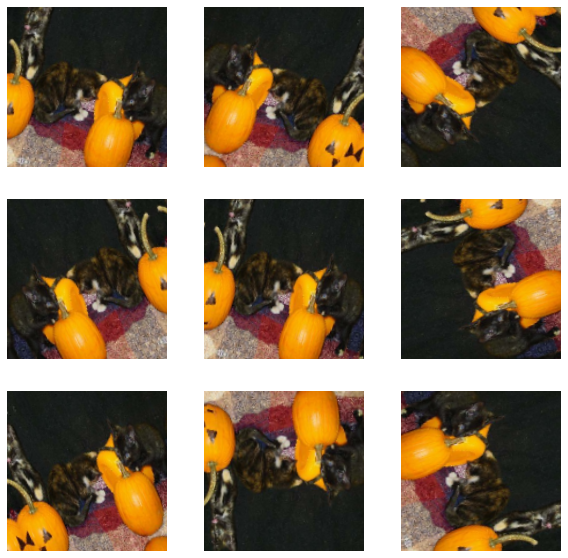

In [ ]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip("horizontal_and_vertical"),
  tf.keras.layers.RandomRotation(0.2),
  tf.keras.layers.RandomZoom(
				height_factor=(-0.05, -0.15),
				width_factor=(-0.05, -0.15)),
])

for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')




---


## Transfer Learning with VGG16
---
Loading pre-trained weights

In [ ]:
def VGG16(include_top=False, weights='imagenet',input_tensor=None,input_shape=None,pooling=False):
  # Not loaded the last two fully connected layers which act as the classifier. 
  # We are just loading the convolutional layers. Note: not specifying the shape of top layers, 
  # the input tensor shape is (None, None, 3),so you can use them for any size of images.
  model = tf.keras.applications.vgg16.VGG16(
                                            include_top=include_top,
                                            weights=weights,
                                            input_tensor=input_tensor,
                                            input_shape=input_shape,
                                            pooling=pooling)  
 
  return model


In [ ]:
base_model = VGG16(input_shape=(160,160,3))
base_model.summary()

58900480/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 160, 160, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 160, 160, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 80, 80, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 80, 80, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 80, 80, 128)       147584    
                                                              

---
Create a new network with base layers taken from VGG

In [ ]:
# Freeze the convolutional base model
base_model.trainable = False
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 160, 160, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 160, 160, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 80, 80, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 80, 80, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 80, 80, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 40, 40, 128)       0     

In [ ]:
# Freeze only specific layers of the base model
def freeze_layer(net,freeze_lay_name):

  # Getting layer number through layer name
  for layer_number, layer in enumerate(net.layers):
    if layer.name == freeze_lay_name:
      lay_nb = layer_number
      break

  # Froze layers
  for layer in base_model.layers[:lay_nb]:
    layer.trainable = False

  return base_model


# Freeze up to specific layer of the base model
base_model = VGG16(input_shape=(160,160,3))
base_model = freeze_layer(base_model,'block5_pool')
base_model.summary()


Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 160, 160, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 160, 160, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 80, 80, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 80, 80, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 80, 80, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 40, 40, 128)       0     

---
Add new trainable layers: a classification head, dense layers...

In [ ]:
# Defining a global average pooling layer and a classfication layer
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = tf.keras.layers.Dense(1)

# Defining other layers to add at the end of the base model
dense_1 = tf.keras.layers.Dense(64)

# use the preprocessing method included with the model.
preprocess_input = tf.keras.applications.vgg16.preprocess_input

# Build a model by chaining together the data augmentation, rescaling, 
# base_model and feature extractor layers using the Keras Functional API. 
inputs = tf.keras.Input(shape=(160, 160, 3))

x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x)
x = global_average_layer(x)

# Add classification layer
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)
model.summary()

# Compile de model
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 160, 160, 3)       0         
                                                                 
 tf.__operators__.getitem (S  (None, 160, 160, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 160, 160, 3)      0         
                                                                 
 vgg16 (Functional)          (None, 5, 5, 512)         14714688  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                      

---
Train network and get training history

In [ ]:
def show_result(acc, val_acc, loss, val_loss):
    plt.rcParams['axes.facecolor']='white'
    f, axarr = plt.subplots(1 , 2)
    f.set_figwidth(10)

    # Accuracy
    axarr[0].plot(acc)
    axarr[0].plot(val_acc)
    axarr[0].set_title('model accuracy')
    axarr[0].set_ylabel('accuracy')
    axarr[0].set_xlabel('epoch')
    axarr[0].legend(['train', 'valid'], loc='upper left')

    # Loss
    axarr[1].plot(loss)
    axarr[1].plot(val_loss)
    axarr[1].set_title('model loss')
    axarr[1].set_ylabel('loss')
    axarr[1].set_xlabel('epoch')
    axarr[1].legend(['train', 'valid'], loc='upper left')
    
    plt.show()

In [ ]:
def Train(model, epochs, train_dataset, validation_dataset, test_dataset): 

    print('Start training')
    # define file name to save the model
    file_name = 'best_model.h5'
    # create checkpoint callbacks to save best model for the validation set
    checkpointer = tf.keras.callbacks.ModelCheckpoint(file_name, monitor='val_accuracy', verbose=10, save_best_only=True)
    # create early stopp callbacks to stop training after not imporvment
    early_stop = tf.keras.callbacks.EarlyStopping(monitor = 'val_accuracy', min_delta = 0.0001, 
                               mode = 'max', patience = 15)
  
    # Make first evaluation
    loss0, accuracy0 = model.evaluate(validation_dataset)
    print("initial loss: {:.2f}".format(loss0))
    print("initial accuracy: {:.2f}".format(accuracy0))


    history = model.fit(train_dataset,
                        epochs=epochs,
                        validation_data=validation_dataset,
                        callbacks=[early_stop,checkpointer])

    
    show_result(history.history['accuracy'], 
              history.history['val_accuracy'],
              history.history['loss'],
              history.history['val_loss'])

    del model
    model = tf.keras.models.load_model(file_name)
    loss_val = model.evaluate(validation_dataset)
    loss_test = model.evaluate(test_dataset)
   
    print("[Validation loss: %f , Validation acc.:%.2f%%]" %(loss_val[0] , 100 * loss_val[1])) 
    print("[Test loss: %f , Test acc.:%.2f%%]" %(loss_test[0] , 100 * loss_test[1])) 


---
Train the network

Start training
16/16 [==============================] - 15s 163ms/step - loss: 3.0055 - accuracy: 0.6420
initial loss: 3.01
initial accuracy: 0.64
Epoch 1/50
63/63 [==============================] - ETA: 0s - loss: 2.3261 - accuracy: 0.5635
Epoch 1: val_accuracy improved from -inf to 0.69000, saving model to best_model.h5
63/63 [==============================] - 9s 125ms/step - loss: 2.3261 - accuracy: 0.5635 - val_loss: 1.9376 - val_accuracy: 0.6900
Epoch 2/50
62/63 [============================>.] - ETA: 0s - loss: 1.8053 - accuracy: 0.5857
Epoch 2: val_accuracy improved from 0.69000 to 0.72200, saving model to best_model.h5
63/63 [==============================] - 7s 111ms/step - loss: 1.8071 - accuracy: 0.5855 - val_loss: 1.6259 - val_accuracy: 0.7220
Epoch 3/50
62/63 [============================>.] - ETA: 0s - loss: 1.5152 - accuracy: 0.6305
Epoch 3: val_accuracy improved from 0.72200 to 0.75000, saving model to best_model.h5
63/63 [==============================] - 7s 112ms/step

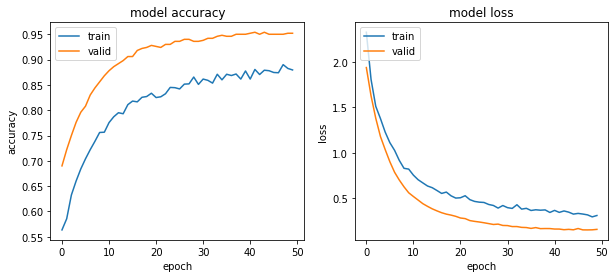

16/16 [==============================] - 2s 84ms/step - loss: 0.2219 - accuracy: 0.9400
[Validation loss: 0.160140 , Validation acc.:95.40%]
[Test loss: 0.221905 , Test acc.:94.00%]


In [ ]:
epochs = 50
Train(model, epochs, train_dataset, validation_dataset,test_dataset)

---
## Class exercise
---
Observe the network performance for different configurations:
* Use pre-trained bottom layers of VGG up to layer name (VGG_LN)
* Extra dense layers (DL)

link pro docs para os resultados [https://docs.google.com/document/d/1y5ebDxYV8G7oZ-pomTfY_PdlD1mLGQtglwukNVNmByc/edit?usp=sharing]

Experiments || VGG_LN || DL || Aluno || Test Acc ||
--- || --- || --- || --- || --- ||
Conf_1 ||  **'block5_pool'**  ||  **None**   || 1 ||
Conf_2 ||  **'block5_pool'**  ||  **Dense_1**  || 2 ||
Conf_3 ||  **'block5_conv3'**  ||  **None**   || 3 ||
Conf_4 ||  **'block5_conv3'**  ||  **Dense_1**   || 4 ||
Conf_5 ||  **'block5_conv2'**  ||  **None**   || 5 ||
Conf_6 ||  **'block5_conv2'**  ||  **Dense_1**   || 6 ||
Conf_7 ||  **'block5_conv1'**  ||  **None**   || 7 ||
Conf_8 ||  **'block5_conv1'**  ||  **Dense_1**   || 8 ||
Conf_9 ||  **'block4_pool'**  ||  **None**   || 9 ||
Conf_10 ||  **'block4_pool'**  ||  **Dense_1**   || 10 ||
Conf_11 ||  **'block4_conv3'**  ||  **None**   || 11 ||
Conf_12 ||  **'block4_conv3'**  ||  **Dense_1**   || 12 ||
Conf_13 ||  **'block4_conv2'**  ||  **Dense_1**   || 13 ||
      

---
# HOMEWORK 1: Transfer learning.
---

**Objectives**:  Provide students with practical experience with \\
*	convolutional neural networks \\
*	VGG16, and \\
*	transfer learning 

**Description**: The project consists of implementing and assessing the performance of a VGG16 used as “backbone” in three scenarios:
1.	Training from scratch
2.	Using a network pre-trained on ImageNet as a feature extractor
3.	Taking a network pre-trained on ImageNet and fine-tuning the layers

**Experiments**: The students are encouraged to evaluate and compare three approaches as illustrated in the figure and described next:

![](https://drive.google.com/uc?id=1Nh9bftFVrJ99Ncv02DqCoMBBH1h-NUij)

1.	Training from scratch: Use the VGG16 model with no prior training, remove the latest layer (prediction layer) and add a classifier. Train the model from scratch and evaluate. 

2.	Using pre-trained network as feature extractor: Use the same model of Exp. 1, but with the VGG16 model pre-trained on ImageNet. Freeze all layers of ResNet50, train and evaluate the model.

3.	Fine-tuning the latest layers: take a pre-trained VGG16 model, unfreeze the last blocks acording to the following: \\
  3-a) - unfreeze the last convolutional blocks (from "block5_conv1"), train and evaluate the model. \\
  3-b) - unfreeze the last convolutional blocks (from "block4_conv1"), train and evaluate the model. \\
  3-c) - unfreeze all convolutional blocks, train and evaluate the model. 


**Dataset**: Beans dataset --> Beans is a dataset of images of beans taken in the field using smartphone cameras. It consists of 3 classes: 2 disease classes and the healthy class. The images have dimension 500x500, resize all of them to 224x224. \\
*	Train url ('https://storage.googleapis.com/ibeans/train.zip') \\
*	Validation url: ('https://storage.googleapis.com/ibeans/validation.zip') \\
*	Test url: ('https://storage.googleapis.com/ibeans/test.zip') \\

Example to define the train dataloader:


In [ ]:
_URL = 'https://storage.googleapis.com/ibeans/train.zip'
path_to_zip = tf.keras.utils.get_file(os.path.basename(_URL), origin=_URL, extract=True)

train_dir = os.path.join(os.path.dirname(path_to_zip),'train')
BATCH_SIZE = 32
IMG_SIZE = (224, 224)

train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

143826944/143812152 [==============================] - 1s 0us/step
Found 1034 files belonging to 3 classes.




Select  good  hyper-parameters values  for  your  training  (try  with  different ones). Use the same hyper-parameters configuration for the three experiments.

**Homework Report**: The final report must contain:
1.	A link to the shared notebook containing your code
2.	A pdf file reporting your experiments, includes the results in the form of a table, and discusse the results

Exp ||	train acc	|| train loss	|| val acc || val loss	|| test acc	|| test loss ||
--- || --- || --- || --- || --- || --- || --- ||
1 || --- || --- || --- || --- || --- || --- ||
2 || --- || --- || --- || --- || --- || --- ||
3-a) || --- || --- || --- || --- || --- || --- ||
3-b) || --- || --- || --- || --- || --- || --- ||
3-c) || --- || --- || --- || --- || --- || --- ||